# **Model Training and Selection**

## *Linear Regression*

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

np.set_printoptions(precision=2)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score

from xgboost import XGBRegressor

RANDOM_STATE = 55

In [124]:
df = pd.read_csv("../data/model_ready.csv")

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,zipcode_98288,zipcode_98354
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,...,False,False,False,False,False,False,False,False,False,False
1,2014-05-02,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,...,False,False,False,False,False,False,False,False,False,False
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,...,False,False,False,False,False,False,False,False,False,False
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,...,False,False,False,False,False,False,False,False,False,False
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,...,False,False,False,False,False,False,False,False,False,False


In [125]:
target = "price_log"

# Remove the original price and date from the features
drop_cols = ["price", "price_log", "date"]

x = df.drop(columns=drop_cols)
y = df[target]

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (4551, 138)
the shape of the targets y is: (4551,)


### split dataset

In [126]:
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (2730, 138)
the shape of the training set (target) is: (2730,)

the shape of the cross validation set (input) is: (910, 138)
the shape of the cross validation set (target) is: (910,)

the shape of the test set (input) is: (911, 138)
the shape of the test set (target) is: (911,)


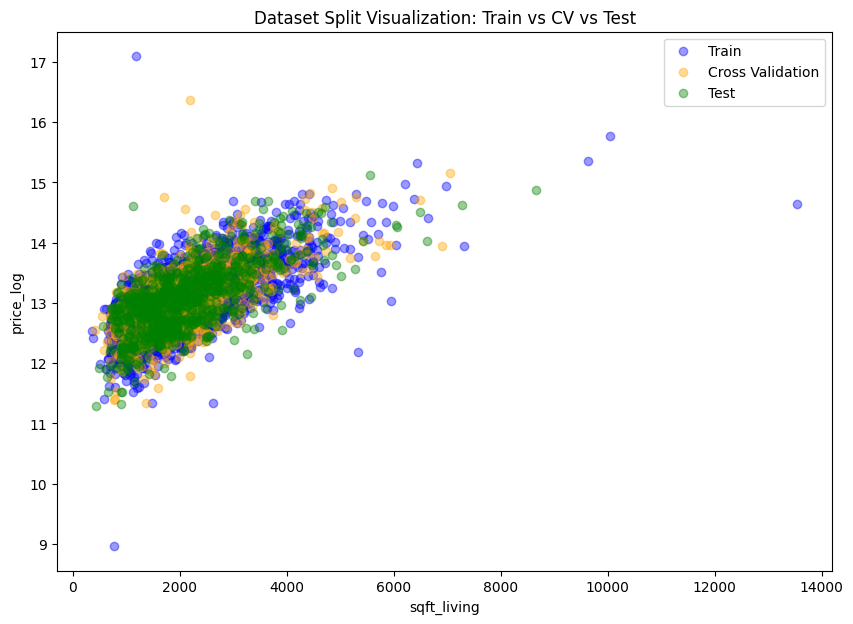

In [127]:
plt.figure(figsize=(10, 7))

# Training data (blue)
plt.scatter(
    x_train["sqft_living"], y_train,
    alpha=0.4, label="Train", color="blue"
)

# Cross-validation data (orange)
plt.scatter(
    x_cv["sqft_living"], y_cv,
    alpha=0.4, label="Cross Validation", color="orange"
)

# Test data (green)
plt.scatter(
    x_test["sqft_living"], y_test,
    alpha=0.4, label="Test", color="green"
)

plt.title("Dataset Split Visualization: Train vs CV vs Test")
plt.xlabel("sqft_living")
plt.ylabel("price_log")
plt.legend()
plt.show()

### feature scaling

In [128]:
scaler_linear = StandardScaler()
X_train_scaled = scaler_linear.fit_transform(x_train)

### train the model

In [129]:
linear_model = LinearRegression()

linear_model.fit(X_train_scaled, y_train )

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### evaluate the model

In [130]:
yhat = linear_model.predict(X_train_scaled)

print(f"training MSE: {mean_squared_error(y_train, yhat) / 2}")

training MSE: 0.02622725194540392


In [131]:
X_cv_scaled = scaler_linear.transform(x_cv)

yhat = linear_model.predict(X_cv_scaled)

print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Cross validation MSE: 0.03883235318391924


### try to apply regularization to see if there's space for improvement

In [132]:
# from 0.01 → 10000
alphas = np.logspace(-2, 4, 50)
results = []

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    train_mse = mean_squared_error(y_train, y_train_pred) / 2

    y_cv_pred = model.predict(X_cv_scaled)
    cv_mse = mean_squared_error(y_cv, y_cv_pred) / 2

    results.append((a, train_mse, cv_mse))

In [133]:
best_alpha, best_Jtrain, best_Jcv = min(results, key=lambda x: x[2])
print("Best alpha:", best_alpha)
print("Best train loss:", best_Jtrain)
print("Best CV loss:", best_Jcv)

Best alpha: 8.68511373751352
Best train loss: 0.026289754713903574
Best CV loss: 0.03870754381369412


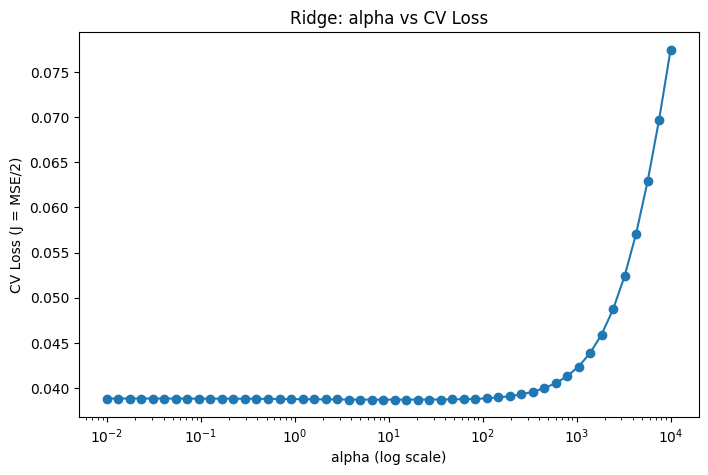

In [134]:
alphas = [a for a, jt, jc in results]
cv_mse = [jc for a, jt, jc in results]

plt.figure(figsize=(8,5))
plt.plot(alphas, cv_mse, marker='o')
plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("CV Loss (J = MSE/2)")
plt.title("Ridge: alpha vs CV Loss")
plt.show()

### test set evaluation

In [142]:
# 1) Prepare scaled features for the test set (using the same scaler_linear)
X_test_scaled = scaler_linear.transform(x_test)

#2) Ridge Regression (best_alpha) Predictions and Metrics on Test
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

y_test_pred_ridge = ridge_best.predict(X_test_scaled)
J_test_ridge = mean_squared_error(y_test, y_test_pred_ridge) / 2
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

print("Test Set Results (target = price_log)")
print(f"Ridge (alpha={best_alpha:.6f}): Test J(MSE/2) = {J_test_ridge:.6f}, RMSE = {rmse_test_ridge:.6f}, R^2 = {r2_test_ridge:.4f}")

# 4) Define accuracy as: the percentage of predicted prices within ±10% of the actual price.
# Because the prediction is log(price), we use exp to revert to price.
price_true = np.exp(y_test)
price_pred_ridge = np.exp(y_test_pred_ridge)

acc10_ridge = np.mean(np.abs(price_pred_ridge - price_true) / price_true <= 0.10)

print("\n'Accuracy' defined as within ±10% on price (after exp)")
print(f"Ridge Regression:   Acc@10% = {acc10_ridge:.4%}")

Test Set Results (target = price_log)
Ridge (alpha=8.685114): Test J(MSE/2) = 0.029394, RMSE = 0.242463, R^2 = 0.8074

'Accuracy' defined as within ±10% on price (after exp)
Ridge Regression:   Acc@10% = 46.6520%


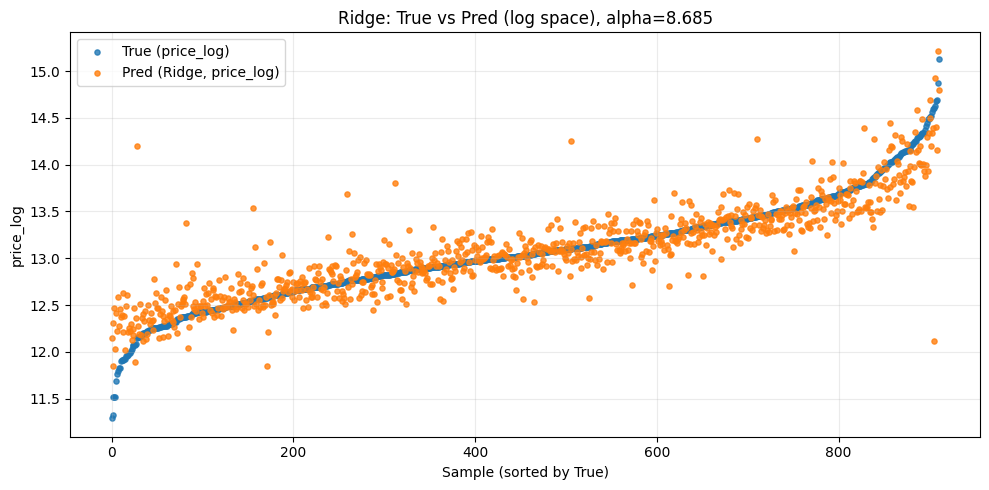

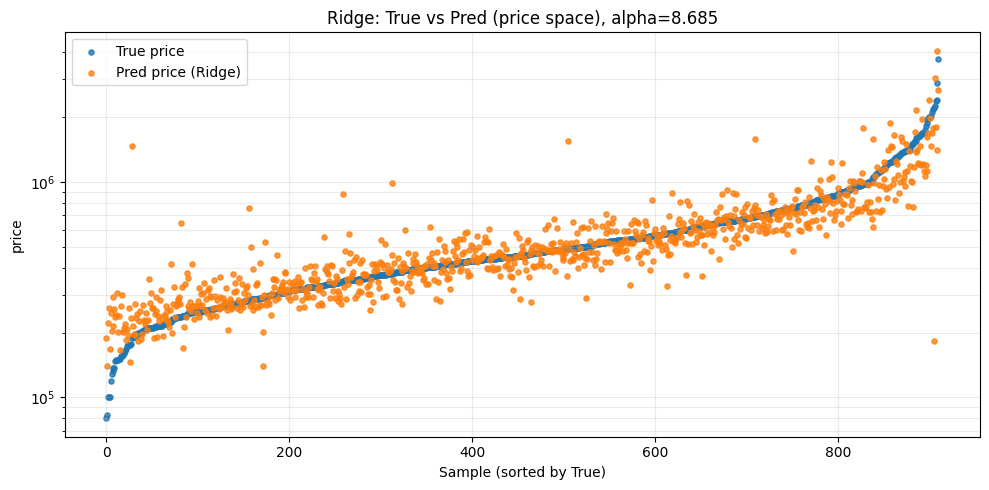

In [141]:
idx = np.argsort(y_test.values if hasattr(y_test, "values") else y_test)

y_true_sorted = (y_test.values if hasattr(y_test, "values") else y_test)[idx]
y_pred_sorted = (y_test_pred_ridge[idx] if hasattr(y_test_pred_ridge, "__len__") else y_test_pred_ridge)

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_true_sorted)), y_true_sorted, s=14, alpha=0.8, label="True (price_log)")
plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, s=14, alpha=0.8, label="Pred (Ridge, price_log)")
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price_log")
plt.title(f"Ridge: True vs Pred (log space), alpha={best_alpha:.3f}")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


price_true_sorted = np.exp(y_true_sorted)
price_pred_sorted = np.exp(y_pred_sorted)

plt.figure(figsize=(10,5))
plt.scatter(range(len(price_true_sorted)), price_true_sorted, s=14, alpha=0.8, label="True price")
plt.scatter(range(len(price_pred_sorted)), price_pred_sorted, s=14, alpha=0.8, label="Pred price (Ridge)")
plt.yscale("log")
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price")
plt.title(f"Ridge: True vs Pred (price space), alpha={best_alpha:.3f}")
plt.grid(True, which="both", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

### linear regression summary and selection

In [143]:
ridge_summary = pd.DataFrame([
    {
        "Model": "Ridge Regression",
        "alpha": best_alpha,
        "Test J (MSE/2)": J_test_ridge,
        "Test RMSE (log-price)": rmse_test_ridge,
        "Test R^2": r2_test_ridge,
        "Acc@10% (price)": acc10_ridge
    }
])

ridge_summary

,Model,alpha,Test J (MSE/2),Test RMSE (log-price),Test R^2,Acc@10% (price)
0,Ridge Regression,8.685114,0.029394,0.242463,0.80735,0.46652


## *Neural Network(Tensorflow)*

### prepare data

In [145]:
# Use the exact same scaler as for linear regression
# Convert to float32 for TensorFlow
X_train_nn = scaler_linear.transform(x_train).astype("float32")
X_cv_nn = scaler_linear.transform(x_cv).astype("float32")

y_train_nn = y_train.astype("float32")
y_cv_nn = y_cv.astype("float32")

X_train_nn.shape, y_train_nn.shape

((2730, 138), (2730,))

### define 3 models with different architectures

In [146]:
# Specify the expected shape of the input.
input_dim = X_train_nn.shape[1]

model_1 = Sequential(
    [
        tf.keras.Input(shape=(input_dim,)),
        Dense(64, activation='relu', name="L1"),
        Dense(32, activation='relu', name="L2"),
        Dense(1, activation='linear', name="L3")
    ]
)

model_2 = Sequential(
    [
        tf.keras.Input(shape=(input_dim,)),
        Dense(64, activation='relu', name="L1"),
        Dense(32, activation='relu', name="L2"),
        Dense(32, activation='relu', name="L3"),
        Dense(64, activation='relu', name="L4"),
        Dense(1, activation='linear', name="L5")
    ]
)

model_3 = Sequential(
    [
        tf.keras.Input(shape=(input_dim,)),
        Dense(128, activation='relu',name="L1"),
        Dense(64, activation='relu',name="L2"),
        Dense(64, activation='relu', name="L3"),
        Dense(64, activation='relu', name="L4"),
        Dense(128, activation='relu', name="L5"),
        Dense(1, activation='linear', name="L6")
    ]
)

### build and train the models

In [147]:
# Initialize lists that will contain the errors for each model
nn_train_mses = []
nn_cv_mses = []

nn_models = [model_1, model_2, model_3]

for model in nn_models:
    # Setup the loss and optimizer
    model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        X_train_nn, y_train_nn,
        epochs=1000,
        verbose=0
    )
    
    print("Done!\n")

    # Record the training MSEs
    yhat = model.predict(X_train_nn)
    train_mse = mean_squared_error(y_train_nn, yhat) / 2
    nn_train_mses.append(train_mse)

    # Record the cross validation MSEs
    yhat = model.predict(X_cv_nn)
    cv_mse = mean_squared_error(y_cv_nn, yhat) / 2
    nn_cv_mses.append(cv_mse)

print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {nn_train_mses[model_num]:.2f}, " +
        f"CV MSE: {nn_cv_mses[model_num]:.2f}"
        )

Training sequential...
Done!

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
Training sequential_1...
Done!

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
Training sequential_2...
Done!

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
RESULTS:
Model 1: Training MSE: 0.01, CV MSE: 0.06
Model 2: Training MSE: 0.02, CV MSE: 0.07
Model 3: Training MSE: 0.08, CV MSE: 0.09


### try to apply regularization to handle high various

In [148]:
reg_params = [0.01, 0.02, 0.04, 0.08, 0.1, 0.5, 1]
results_nn = []

def build_model(lambda_l2):
    l2_reg = l2(lambda_l2)
    return Sequential([
        tf.keras.Input(shape=(input_dim,)),
        # Apply L2 regularization to all hidden layers
        Dense(64, activation='relu', kernel_regularizer=l2_reg, name="L1"),
        Dense(32, activation='relu', kernel_regularizer=l2_reg, name="L2"),
        Dense(1, activation='linear', name="L3")
    ])

# Iterate through each regularization parameter
for lam in reg_params:
    model = build_model(lam)

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    history = model.fit(
        X_train_nn, y_train_nn,
        epochs=1000,
        verbose=0,
        validation_data=(X_cv_nn, y_cv_nn),
    )

    # Extract the final train MSE and validation MSE
    train_mse = history.history["loss"][-1] / 2.0
    cv_mse = history.history["val_loss"][-1] / 2.0

    results_nn.append((lam, train_mse, cv_mse))

In [149]:
best_lambda, best_train_mse, best_cv_mse = min(results_nn, key=lambda x: x[2])
print("Best λ:", best_lambda)
print("Best train loss:", best_train_mse)
print("Best CV loss:", best_cv_mse)

Best λ: 0.01
Best train loss: 0.04028584435582161
Best CV loss: 0.049315594136714935


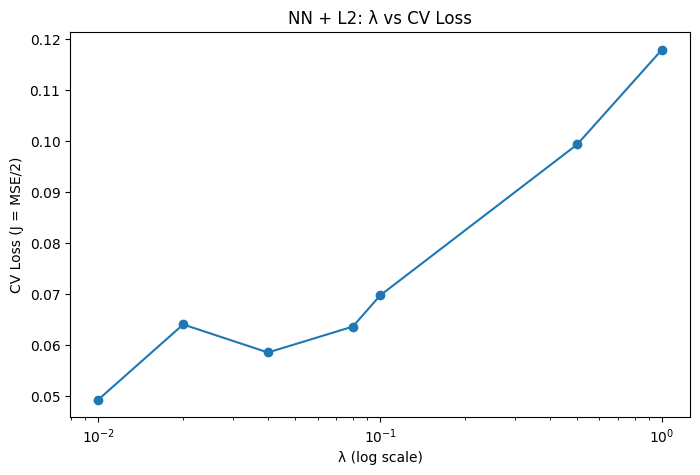

In [150]:
lambdas = [lam for lam, Jtrain, Jcv in results_nn]
cv_J = [Jcv for lam, Jtrain, Jcv in results_nn]

plt.figure(figsize=(8, 5))
plt.plot(lambdas, cv_J, marker='o')
plt.xscale("log")
plt.xlabel("λ (log scale)")
plt.ylabel("CV Loss (J = MSE/2)")
plt.title("NN + L2: λ vs CV Loss")
plt.show()

### test set evaluation

In [152]:
# NN Model 1 (+ L2 Regularization) with best lambda: 0.01
best_lambda = 0.01

# Make sure you have test set prepared with the SAME scaler
X_test_nn = scaler_linear.transform(x_test).astype("float32")
y_test_nn = y_test.astype("float32")

def build_reg_model_1(lambda_l2, input_dim):
    l2_reg = l2(lambda_l2)
    return Sequential([
        tf.keras.Input(shape=(input_dim,)),
        Dense(64, activation='relu', kernel_regularizer=l2_reg, name="L1"),
        Dense(32, activation='relu', kernel_regularizer=l2_reg, name="L2"),
        Dense(1, activation='linear', name="L3")
    ])

reg_model_1 = build_reg_model_1(best_lambda, input_dim)
reg_model_1.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
)

history = reg_model_1.fit(
    X_train_nn, y_train_nn,
    epochs=1000,
    verbose=0,
    validation_data=(X_cv_nn, y_cv_nn)
)

# Evaluate on Test
y_test_pred = reg_model_1.predict(X_test_nn, verbose=0)
test_J = mean_squared_error(y_test_nn, y_test_pred) / 2
test_rmse = np.sqrt(mean_squared_error(y_test_nn, y_test_pred))
test_r2 = r2_score(y_test_nn, y_test_pred)

print("Test Set Results (target = price_log)")
print(f" NN Model 1 (+L2, alpha={best_lambda}): Test J(MSE/2) = {test_J:.6f}, RMSE = {test_rmse:.6f}, R^2 = {test_r2:.4f}")

y_test_price = np.exp(y_test_nn.to_numpy().reshape(-1))
y_test_price_pred = np.exp(np.squeeze(y_test_pred))   

relative_error = np.abs(y_test_price_pred - y_test_price) / y_test_price
test_accuracy_10pct = np.mean(relative_error <= 0.10)

print("\n'Accuracy' defined as within ±10% on price (after exp)")
print(f":NN Model 1 (+L2)   Acc@10% = {test_accuracy_10pct:.4%}")

Test Set Results (target = price_log)
 NN Model 1 (+L2, alpha=0.01): Test J(MSE/2) = 0.036379, RMSE = 0.269737, R^2 = 0.7616

'Accuracy' defined as within ±10% on price (after exp)
:NN Model 1 (+L2)   Acc@10% = 39.8463%


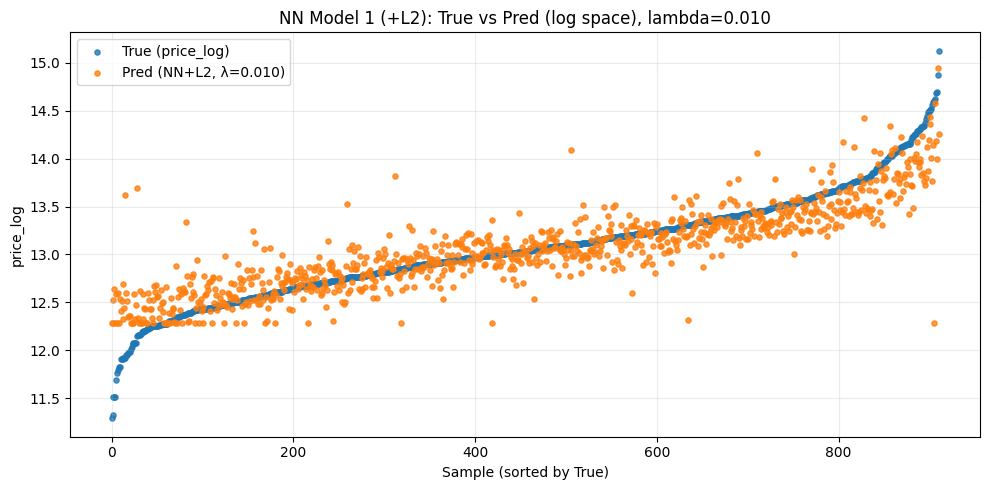

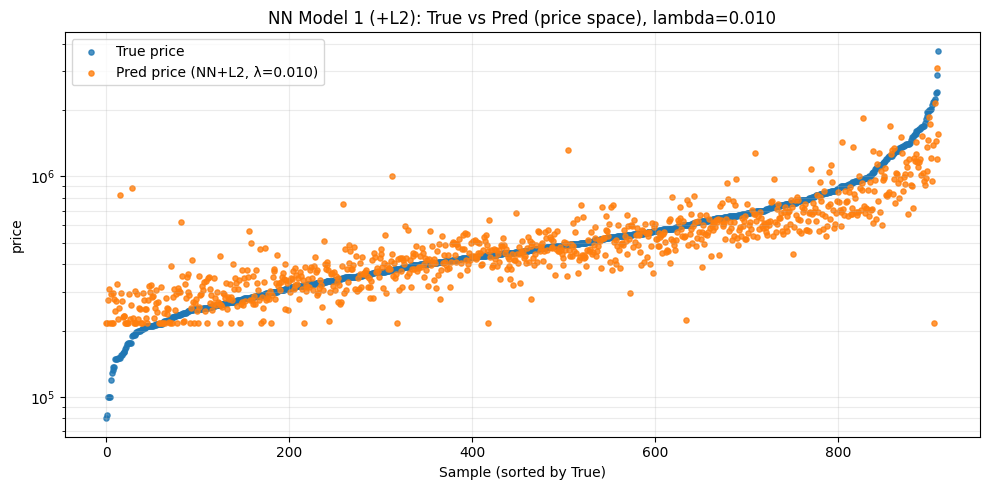

In [154]:
y_test_pred_nn = np.squeeze(y_test_pred)

y_test_arr = y_test_nn.values if hasattr(y_test_nn, "values") else np.asarray(y_test_nn)

idx = np.argsort(y_test_arr)

y_true_sorted = y_test_arr[idx]
y_pred_sorted = y_test_pred_nn[idx]

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_true_sorted)), y_true_sorted, s=14, alpha=0.8, label="True (price_log)")
plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, s=14, alpha=0.8, label=f"Pred (NN+L2, λ={best_lambda:.3f})")
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price_log")
plt.title(f"NN Model 1 (+L2): True vs Pred (log space), lambda={best_lambda:.3f}")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

price_true_sorted = np.exp(y_true_sorted)
price_pred_sorted = np.exp(y_pred_sorted)

plt.figure(figsize=(10, 5))
plt.scatter(range(len(price_true_sorted)), price_true_sorted, s=14, alpha=0.8, label="True price")
plt.scatter(range(len(price_pred_sorted)), price_pred_sorted, s=14, alpha=0.8, label=f"Pred price (NN+L2, λ={best_lambda:.3f})")
plt.yscale("log") 
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price")
plt.title(f"NN Model 1 (+L2): True vs Pred (price space), lambda={best_lambda:.3f}")
plt.grid(True, which="both", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

### neural network summary and selection

In [155]:
nn_summary = pd.DataFrame([
    {
        "Model": "Neural Network",
        "alpha": best_lambda,
        "Test J (MSE/2)": test_J,
        "Test RMSE (log-price)": test_rmse,
        "Test R^2": test_r2,
        "Acc@10% (price)": test_accuracy_10pct
    }
])

nn_summary

,Model,alpha,Test J (MSE/2),Test RMSE (log-price),Test R^2,Acc@10% (price)
0,Neural Network,0.01,0.036379,0.269737,0.761571,0.398463


## *Decesion Tree*

### Random Forest

In [157]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

### choose the bset parameter with min_samples_split

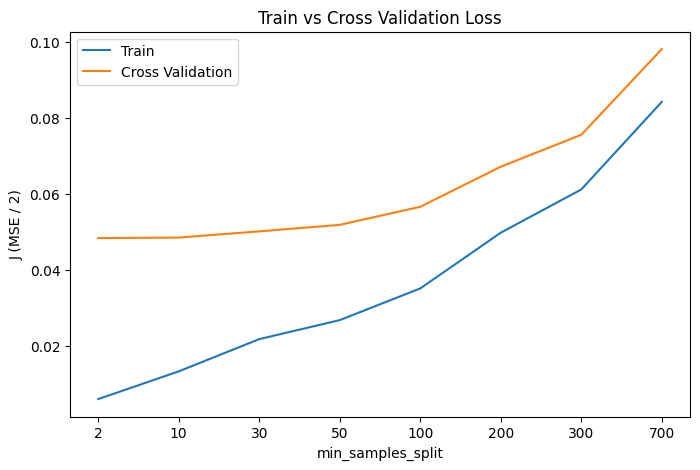

In [158]:
J_train_list = []
J_cv_list = []
for min_samples_split in min_samples_split_list:
    model = RandomForestRegressor(
        min_samples_split=min_samples_split,
        random_state=RANDOM_STATE).fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    predictions_cv = model.predict(x_cv)
    J_train = mean_squared_error(y_train, predictions_train) / 2
    J_cv = mean_squared_error(y_cv, predictions_cv) / 2
    J_train_list.append(J_train)
    J_cv_list.append(J_cv)

plt.figure(figsize=(8,5))
plt.plot(J_train_list)
plt.plot(J_cv_list)
plt.title('Train vs Cross Validation Loss')
plt.xlabel('min_samples_split')
plt.ylabel('J (MSE / 2)')
plt.xticks(
    ticks=range(len(min_samples_split_list)),
    labels=min_samples_split_list
)
plt.legend(['Train', 'Cross Validation'])
plt.show()

30 and 50 perform similarly, but 30 achieves the lowest CV loss, so it is preferred.

### choose the bset parameter with max_depth_list

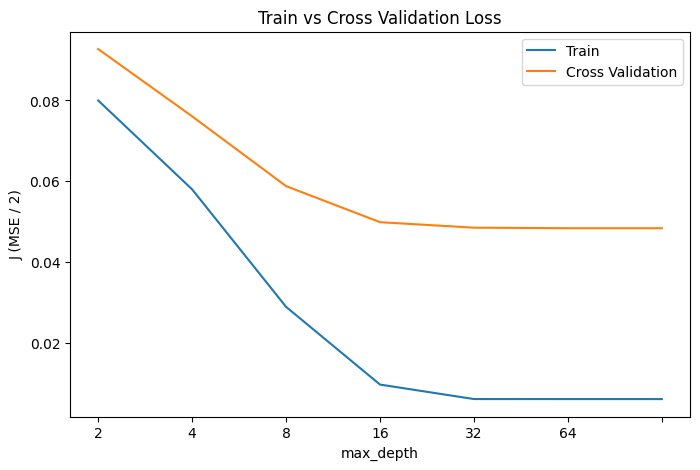

In [159]:
J_train_list = []
J_cv_list = []
for max_depth in max_depth_list:
    model = RandomForestRegressor(
        max_depth = max_depth,
        random_state = RANDOM_STATE).fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    predictions_cv = model.predict(x_cv)
    J_train = mean_squared_error(y_train, predictions_train) / 2
    J_cv = mean_squared_error(y_cv, predictions_cv) / 2
    J_train_list.append(J_train)
    J_cv_list.append(J_cv)

plt.figure(figsize=(8,5))
plt.plot(J_train_list)
plt.plot(J_cv_list)
plt.title("Train vs Cross Validation Loss")
plt.xlabel("max_depth")
plt.ylabel("J (MSE / 2)")
plt.xticks(
    ticks=range(len(max_depth_list)),
    labels=max_depth_list
)
plt.legend(["Train", "Cross Validation"])
plt.show()

The performance of 32 and 64 is very similar, but 32 has the lowest cross-validation loss, so max_depth = 32 is preferred.

### choose the bset parameter with n_estimators

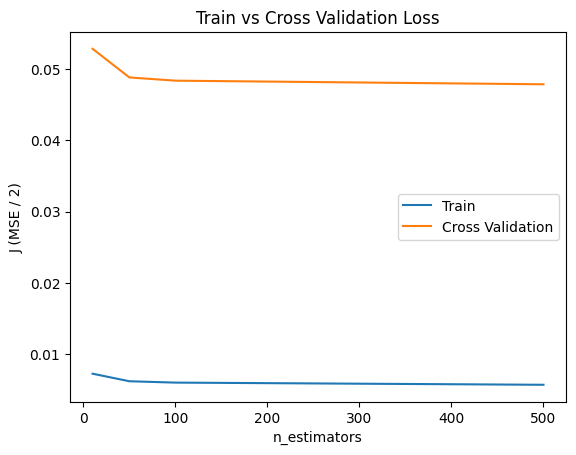

In [160]:
J_train_list = []
J_cv_list = []
for n_estimators in n_estimators_list:
    model = RandomForestRegressor(
        n_estimators=n_estimators,random_state=RANDOM_STATE).fit(x_train, y_train)
    predictions_train = model.predict(x_train)
    predictions_cv = model.predict(x_cv)
    J_train = mean_squared_error(y_train, predictions_train) / 2
    J_cv = mean_squared_error(y_cv, predictions_cv) / 2
    J_train_list.append(J_train)
    J_cv_list.append(J_cv)

plt.title("Train vs Cross Validation Loss")
plt.xlabel("n_estimators")
plt.ylabel("J (MSE / 2)")
plt.plot(n_estimators_list, J_train_list)
plt.plot(n_estimators_list, J_cv_list)
plt.legend(["Train", "Cross Validation"])
plt.show()

The performance of 50, 100 and 500 is very close, but 500 achieved the lowest validation set loss and was therefore selected as the optimal n_estimators.

### fit the model with the best parameter

In [161]:
random_forest_model = RandomForestRegressor(
    n_estimators = 500,
    max_depth = 32,
    min_samples_split = 30
).fit(x_train, y_train)

In [162]:
yhat_train = random_forest_model.predict(x_train)
yhat_cv    = random_forest_model.predict(x_cv)

train_mse = mean_squared_error(y_train, yhat_train) / 2
cv_mse    = mean_squared_error(y_cv, yhat_cv) / 2

print(f"Train MSE: {train_mse:.6f}")
print(f"Validation MSE: {cv_mse:.6f}")

Train MSE: 0.021171
Validation MSE: 0.049738


### test set evaluation

In [163]:
# Random Forest: Predict on Test
y_test_pred_rf = random_forest_model.predict(x_test)

# Test J (MSE / 2)
J_test_rf = mean_squared_error(y_test, y_test_pred_rf) / 2

# Test RMSE (log-price)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

# Test R^2
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print("Test Set Results (target = price_log)")
print(
    f"Random Forest: Test J(MSE/2) = {J_test_rf:.6f}, "
    f"RMSE = {rmse_test_rf:.6f}, "
    f"R^2 = {r2_test_rf:.4f}"
)

# Convert back to original price space
price_true = np.exp(y_test)
price_pred_rf = np.exp(y_test_pred_rf)

acc10_rf = np.mean(
    np.abs(price_pred_rf - price_true) / price_true <= 0.10
)

print("\n'Accuracy' defined as within ±10% on price (after exp)")
print(f"Random Forest: Acc@10% = {acc10_rf:.4%}")

Test Set Results (target = price_log)
Random Forest: Test J(MSE/2) = 0.037708, RMSE = 0.274619, R^2 = 0.7529

'Accuracy' defined as within ±10% on price (after exp)
Random Forest: Acc@10% = 40.8342%


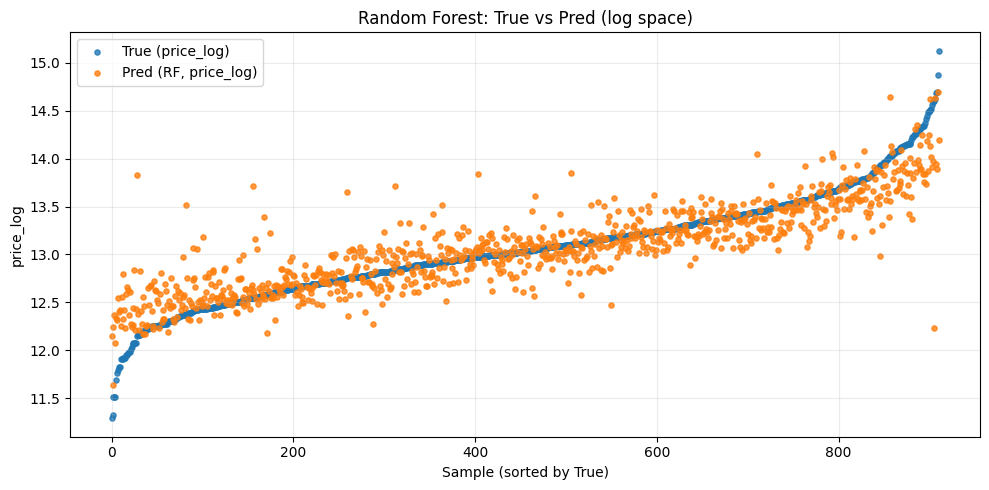

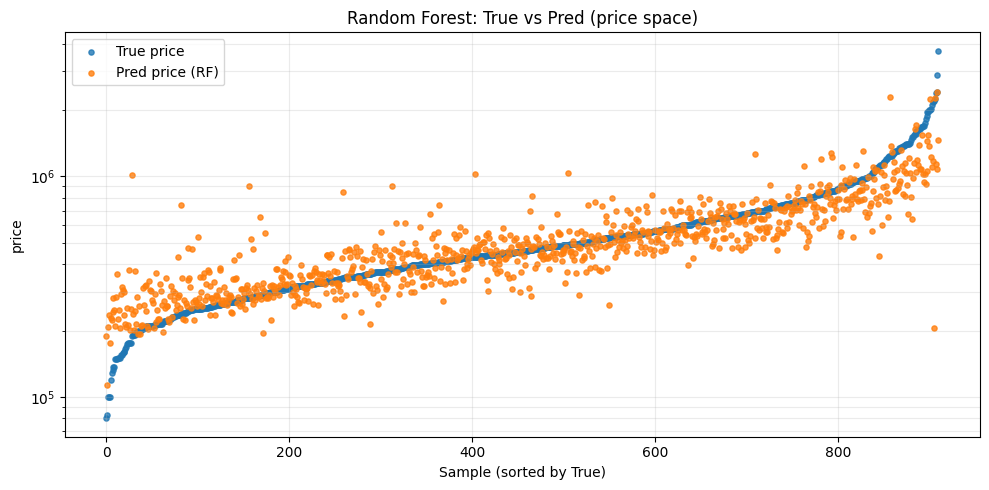

In [170]:
idx = np.argsort(y_test.values if hasattr(y_test, "values") else y_test)

y_true_sorted = (y_test.values if hasattr(y_test, "values") else y_test)[idx]
y_pred_sorted = (
    y_test_pred_rf[idx]
    if hasattr(y_test_pred_rf, "__len__")
    else y_test_pred_rf
)

plt.figure(figsize=(10, 5))
plt.scatter(
    range(len(y_true_sorted)),
    y_true_sorted,
    s=14,
    alpha=0.8,
    label="True (price_log)"
)
plt.scatter(
    range(len(y_pred_sorted)),
    y_pred_sorted,
    s=14,
    alpha=0.8,
    label="Pred (RF, price_log)"
)
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price_log")
plt.title("Random Forest: True vs Pred (log space)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


price_true_sorted = np.exp(y_true_sorted)
price_pred_sorted = np.exp(y_pred_sorted)

plt.figure(figsize=(10, 5))
plt.scatter(
    range(len(price_true_sorted)),
    price_true_sorted,
    s=14,
    alpha=0.8,
    label="True price"
)
plt.scatter(
    range(len(price_pred_sorted)),
    price_pred_sorted,
    s=14,
    alpha=0.8,
    label="Pred price (RF)"
)
plt.yscale("log")
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price")
plt.title("Random Forest: True vs Pred (price space)")
plt.grid(True, which="both", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

In [165]:
rf_summary = pd.DataFrame([
    {
        "Model": "Random Forest",
        "alpha": None,
        "Test J (MSE/2)": J_test_rf,
        "Test RMSE (log-price)": rmse_test_rf,
        "Test R^2": r2_test_rf,
        "Acc@10% (price)": acc10_rf
    }
])

rf_summary

,Model,alpha,Test J (MSE/2),Test RMSE (log-price),Test R^2,Acc@10% (price)
0,Random Forest,None,0.037708,0.274619,0.752862,0.408342


### XGBoost

In [118]:
xgb_model = XGBRegressor(n_estimators = 500, learning_rate = 0.1, verbosity = 1,random_state = RANDOM_STATE)
xgb_model.fit(x_train, y_train, eval_set = [(x_cv, y_cv)], early_stopping_rounds = 10)

[0]	validation_0-rmse:11.33026
[1]	validation_0-rmse:10.20082
[2]	validation_0-rmse:9.18513
[3]	validation_0-rmse:8.27002
[4]	validation_0-rmse:7.44774
[5]	validation_0-rmse:6.70683
[6]	validation_0-rmse:6.04050
[7]	validation_0-rmse:5.44156
[8]	validation_0-rmse:4.90301
[9]	validation_0-rmse:4.41725
[10]	validation_0-rmse:3.98151
[11]	validation_0-rmse:3.58933
[12]	validation_0-rmse:3.23711
[13]	validation_0-rmse:2.92026
[14]	validation_0-rmse:2.63477
[15]	validation_0-rmse:2.37953
[16]	validation_0-rmse:2.14897
[17]	validation_0-rmse:1.94293
[18]	validation_0-rmse:1.75728
[19]	validation_0-rmse:1.59174
[20]	validation_0-rmse:1.44337
[21]	validation_0-rmse:1.30973
[22]	validation_0-rmse:1.18960
[23]	validation_0-rmse:1.08233
[24]	validation_0-rmse:0.98698
[25]	validation_0-rmse:0.90295
[26]	validation_0-rmse:0.82757
[27]	validation_0-rmse:0.76064
[28]	validation_0-rmse:0.70233
[29]	validation_0-rmse:0.65074
[30]	validation_0-rmse:0.60514
[31]	validation_0-rmse:0.56449
[32]	validation_

/Users/yinyueyang/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-rmse:0.31910
[56]	validation_0-rmse:0.31817
[57]	validation_0-rmse:0.31697
[58]	validation_0-rmse:0.31614
[59]	validation_0-rmse:0.31457
[60]	validation_0-rmse:0.31388
[61]	validation_0-rmse:0.31305
[62]	validation_0-rmse:0.31178
[63]	validation_0-rmse:0.31084
[64]	validation_0-rmse:0.31050
[65]	validation_0-rmse:0.30983
[66]	validation_0-rmse:0.30920
[67]	validation_0-rmse:0.30846
[68]	validation_0-rmse:0.30778
[69]	validation_0-rmse:0.30707
[70]	validation_0-rmse:0.30670
[71]	validation_0-rmse:0.30633
[72]	validation_0-rmse:0.30591
[73]	validation_0-rmse:0.30537
[74]	validation_0-rmse:0.30467
[75]	validation_0-rmse:0.30402
[76]	validation_0-rmse:0.30361
[77]	validation_0-rmse:0.30318
[78]	validation_0-rmse:0.30271
[79]	validation_0-rmse:0.30236
[80]	validation_0-rmse:0.30191
[81]	validation_0-rmse:0.30191
[82]	validation_0-rmse:0.30141
[83]	validation_0-rmse:0.30105
[84]	validation_0-rmse:0.30071
[85]	validation_0-rmse:0.30037
[86]	validation_0-rmse:0.30018
[87]	val

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


In [119]:
xgb_model.best_iteration

199

In [120]:
print(
    f"Train MSE: {(mean_squared_error(y_train, xgb_model.predict(x_train)) / 2):.4f}\n"
    f"Validation MSE: {(mean_squared_error(y_cv, xgb_model.predict(x_cv)) / 2):.4f}"
)

Train MSE: 0.0096
Validation MSE: 0.0414


### test set evalution

In [168]:
# XGBoost: Predict on Test
y_test_pred_xgb = xgb_model.predict(x_test)

# Test J (MSE / 2)
J_test_xgb = mean_squared_error(y_test, y_test_pred_xgb) / 2

# Test RMSE (log-price)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

# Test R^2
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print("Test Set Results (target = price_log)")
print(
    f"XGBoost: Test J(MSE/2) = {J_test_xgb:.6f}, "
    f"RMSE = {rmse_test_xgb:.6f}, "
    f"R^2 = {r2_test_xgb:.4f}"
)

# Convert back to original price space
price_true = np.exp(y_test)
price_pred_xgb = np.exp(y_test_pred_xgb)

acc10_xgb = np.mean(
    np.abs(price_pred_xgb - price_true) / price_true <= 0.10
)

print("\n'Accuracy' defined as within ±10% on price (after exp)")
print(f"XGBoost: Acc@10% = {acc10_xgb:.4%}")

Test Set Results (target = price_log)
XGBoost: Test J(MSE/2) = 0.029323, RMSE = 0.242169, R^2 = 0.8078

'Accuracy' defined as within ±10% on price (after exp)
XGBoost: Acc@10% = 46.9813%


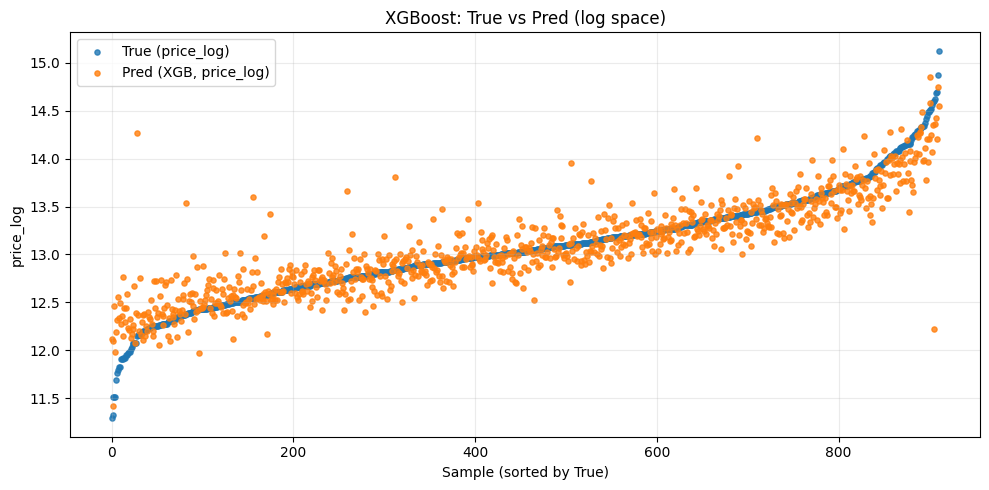

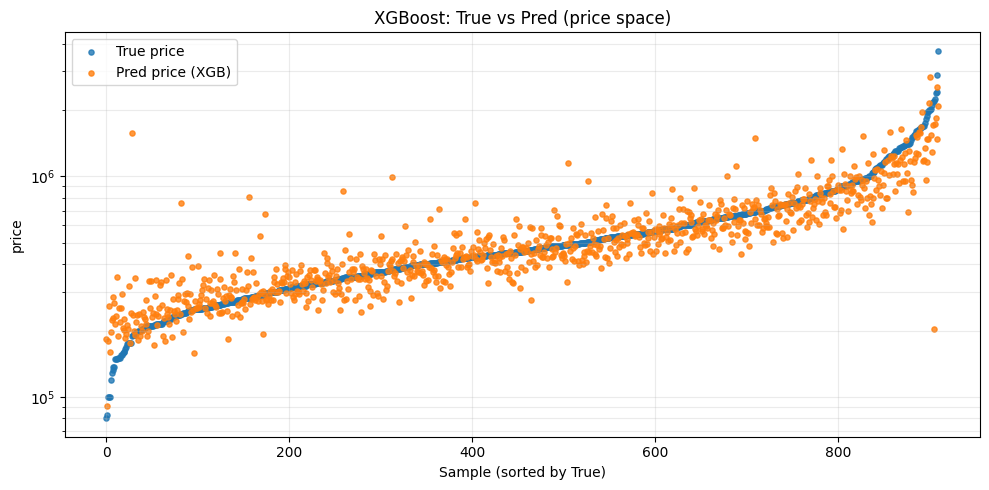

In [171]:
idx = np.argsort(y_test.values if hasattr(y_test, "values") else y_test)

y_true_sorted = (y_test.values if hasattr(y_test, "values") else y_test)[idx]
y_pred_sorted = (
    y_test_pred_xgb[idx]
    if hasattr(y_test_pred_xgb, "__len__")
    else y_test_pred_xgb
)

plt.figure(figsize=(10, 5))
plt.scatter(
    range(len(y_true_sorted)),
    y_true_sorted,
    s=14,
    alpha=0.8,
    label="True (price_log)"
)
plt.scatter(
    range(len(y_pred_sorted)),
    y_pred_sorted,
    s=14,
    alpha=0.8,
    label="Pred (XGB, price_log)"
)
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price_log")
plt.title("XGBoost: True vs Pred (log space)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


price_true_sorted = np.exp(y_true_sorted)
price_pred_sorted = np.exp(y_pred_sorted)

plt.figure(figsize=(10, 5))
plt.scatter(
    range(len(price_true_sorted)),
    price_true_sorted,
    s=14,
    alpha=0.8,
    label="True price"
)
plt.scatter(
    range(len(price_pred_sorted)),
    price_pred_sorted,
    s=14,
    alpha=0.8,
    label="Pred price (XGB)"
)
plt.yscale("log")
plt.xlabel("Sample (sorted by True)")
plt.ylabel("price")
plt.title("XGBoost: True vs Pred (price space)")
plt.grid(True, which="both", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

In [172]:
xgb_summary = pd.DataFrame([
    {
        "Model": "XGBoost",
        "alpha": None,
        "Test J (MSE/2)": J_test_xgb,
        "Test RMSE (log-price)": rmse_test_xgb,
        "Test R^2": r2_test_xgb,
        "Acc@10% (price)": acc10_xgb
    }
])

xgb_summary

,Model,alpha,Test J (MSE/2),Test RMSE (log-price),Test R^2,Acc@10% (price)
0,XGBoost,None,0.029323,0.242169,0.807817,0.469813


### decesion tree summary and selection

In [173]:
xgb_summary = pd.DataFrame([
    {
        "Model": "XGBoost",
        "alpha": None,
        "Test J (MSE/2)": J_test_xgb,
        "Test RMSE (log-price)": rmse_test_xgb,
        "Test R^2": r2_test_xgb,
        "Acc@10% (price)": acc10_xgb
    }
])

xgb_summary

,Model,alpha,Test J (MSE/2),Test RMSE (log-price),Test R^2,Acc@10% (price)
0,XGBoost,None,0.029323,0.242169,0.807817,0.469813


## *Model Selection*

### Compare the best-performing models in supervised learning algorithms for housing price prediction projects.

In [174]:
cols = ["Model", "alpha", "Test J (MSE/2)", "Test RMSE (log-price)", "Test R^2", "Acc@10% (price)"]

xgb_summary   = xgb_summary.reindex(columns=cols)
nn_summary    = nn_summary.reindex(columns=cols)
ridge_summary = ridge_summary.reindex(columns=cols)

all_summary = pd.concat([xgb_summary, nn_summary, ridge_summary], ignore_index=True)

all_summary = all_summary.sort_values("Test J (MSE/2)", ascending=True).reset_index(drop=True)

all_summary

/var/folders/5_/1zk9fggs7tg_yk0ff1r0bvnw0000gn/T/ipykernel_18751/553791585.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_summary = pd.concat([xgb_summary, nn_summary, ridge_summary], ignore_index=True)


,Model,alpha,Test J (MSE/2),Test RMSE (log-price),Test R^2,Acc@10% (price)
0,XGBoost,NaN,0.029323,0.242169,0.807817,0.469813
1,Ridge Regression,8.685114,0.029394,0.242463,0.807350,0.466520
2,Neural Network,0.010000,0.036379,0.269737,0.761571,0.398463


Based on the test set evaluation, XGBoost is selected as the final optimal model.